# Notebook

This notebook gives a demo of using filters on data sourced from the Physionet Challenge 2015. It requires the following packages:

* numpy
* scipy
* wfdb
* matplotlib



In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import os
import wfdb
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

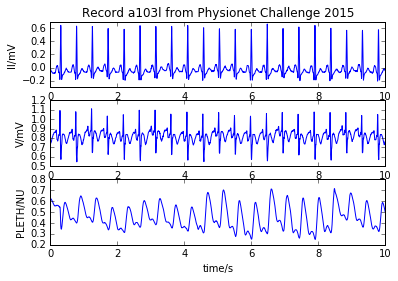

In [2]:
# Read the wfdb file, plot the last part of the signals
sig, fields=wfdb.rdsamp('sampledata/a103l')
wfdb.plotwfdb(sig[80000:,:], fields, title='Record a103l from Physionet Challenge 2015') 

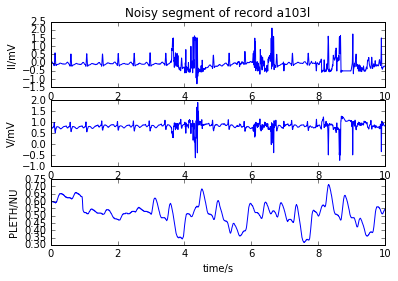

In [3]:
# There is a noisy section of this signal - between 4:20 and 4:25 (260 and 265 seconds)
sig, fields=wfdb.rdsamp('sampledata/a103l')
fs = 250
seg = sig[260*fs:270*fs,:]

wfdb.plotwfdb(seg, fields, title='Noisy segment of record a103l') 

As we can see above - there is a bit of noise in our signal. This demo will focus on removing that noise. Let's focus on the first signal.

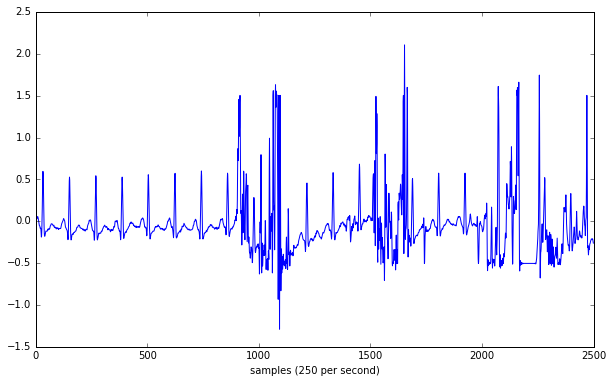

In [4]:
# plot only the first signal
plt.figure(figsize=[10,6])
plt.plot(seg[:,0],'b-')
plt.xlabel('samples (250 per second)')
plt.show()

The signal starts to oscillate very quickly at the end of segment - we would call this high frequency noise, because the oscillations are quite quick. Conversely, if we saw very slow oscillations (say the signal moved up and down over the course of several seconds), we would call this low frequency noise.

Let's get a better intuition for this by plotting the frequency against time: a spectrogram.

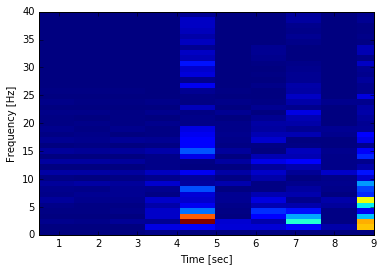

In [5]:
f, t, Sxx = scipy.signal.spectrogram(seg[:,0], fs=fs, window=('tukey', 0.25),
                                     nperseg=256, return_onesided=True,
                                     scaling='spectrum', mode='psd')

plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.axis([0.5,9.0,0,40])
plt.show()

Looking at the spectrogram, we can see clear contamination between 4-5 seconds, 7-8 seconds, and 8.5-9 seconds. Unfortunately, this noise will be non-trivial to remove, because it overlaps with our the frequency content of the normal signal (0-40 Hz). But we can try!

We will filter this signal using the window method. The window method involves convolving a fixed window across the signal. For example, if we convolved a rectangle, we can imagine we would smooth out any quick bumps, because every sample would be replaced by the average of all of its neighbours. Let's create the window and take a look at it.

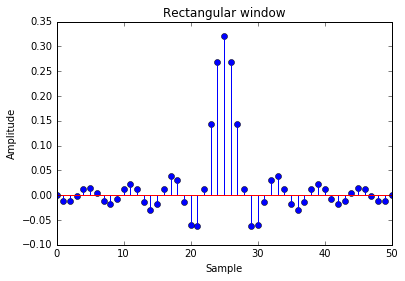

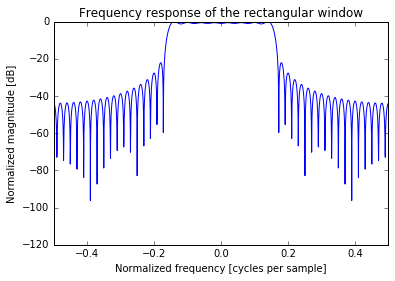

In [6]:
numtaps = 51
f = 40
nyq = np.floor(fs/2)
window = signal.firwin(numtaps, f, nyq=nyq, pass_zero=True,
                  window='boxcar', scale=False)
plt.figure()
plt.stem(window)
plt.title("Rectangular window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.figure()
A = scipy.fftpack.fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(scipy.fftpack.fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the rectangular window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
plt.show()

Note that the rectangular window is not perfectly rectangular - because that would require an infinitely long window. Let's see how our signal looks filtered with a rectangular window:

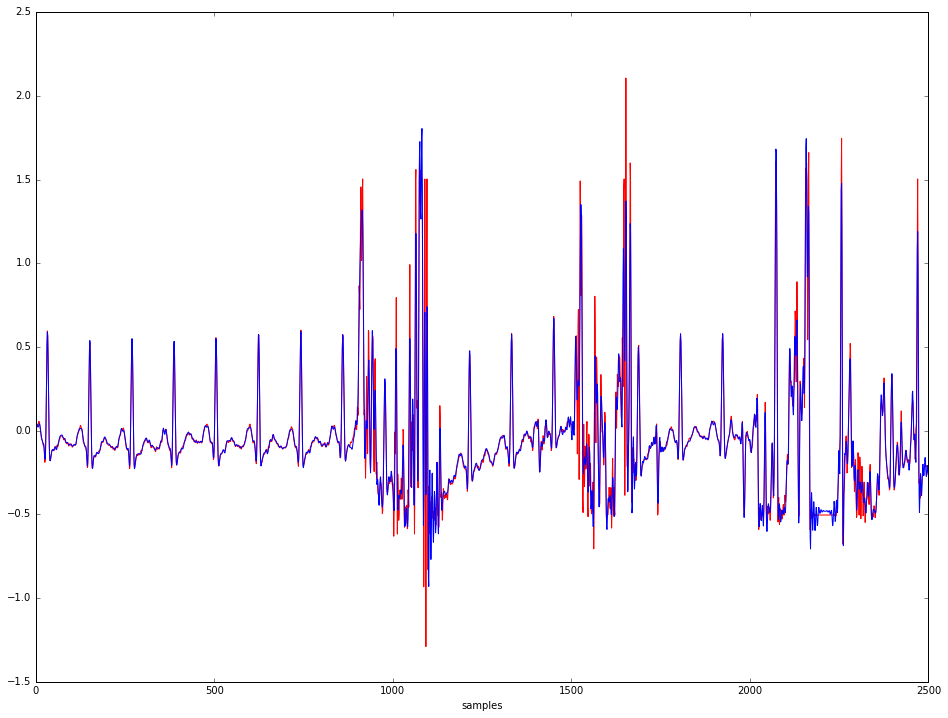

In [7]:
y = scipy.signal.filtfilt(window, 1, seg[:,0])

# plot the data
plt.figure(figsize=[16,12])

plt.plot(seg[:,0],'r-')
plt.plot(y,'b-')
plt.xlabel('samples')
plt.show()

We can see how the high frequency components have been smoothed out the signal - the sharp changes in the noise peaks have been smoothed out. Let's try a different window: the Hamming window.

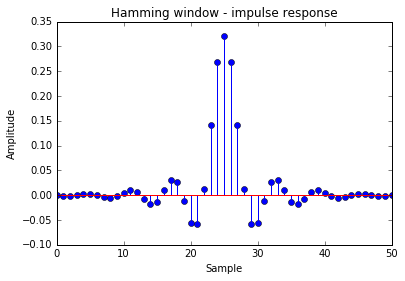

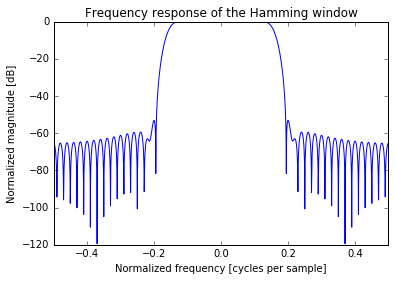

In [8]:
order=50
f_high=40
window = scipy.signal.firwin(order+1, f_high, nyq=np.floor(fs/2), pass_zero=True,
                  window='hamming', scale=False)

# hamming window
plt.figure()
plt.stem(window)
plt.title("Hamming window - impulse response")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.figure()
A = scipy.fftpack.fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(scipy.fftpack.fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Hamming window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
plt.show()

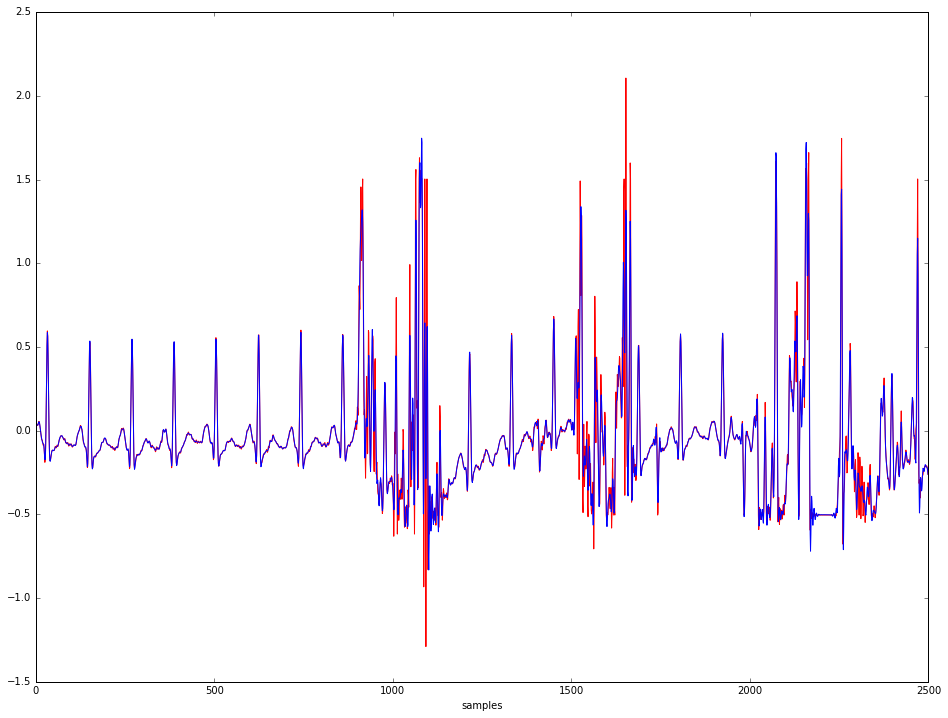

In [9]:
y = scipy.signal.filtfilt(window, 1, seg[:,0])

# plot the data 
plt.figure(figsize=[16,12])
plt.plot(seg[:,0],'r-')
plt.plot(y,'b-')
plt.xlabel('samples')
plt.show()

We can also make band pass filters easily by passing a list as the cutoff: here we specify a [5,40] Hz pass band (if we wanted to make a [5,40] Hz *stop* band, we would set `pass_zero=True`).

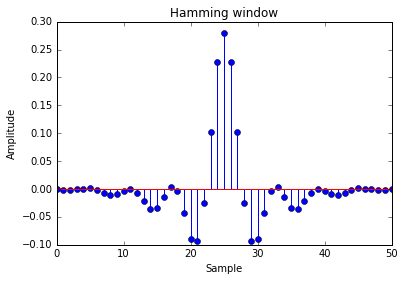

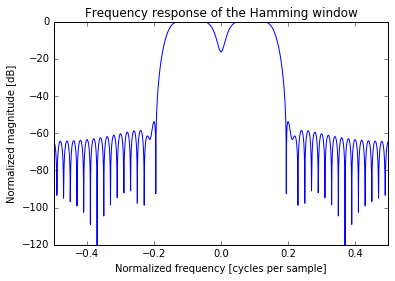

In [10]:
order=50
f_low=5
f_high=40
window = scipy.signal.firwin(order+1, [f_low, f_high], nyq=np.floor(fs/2), pass_zero=False,
                  window='hamming', scale=False)

# hamming window
plt.figure()
plt.stem(window)
plt.title("Hamming window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

plt.figure()
A = scipy.fftpack.fft(window, 2048) / (len(window)/2.0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(scipy.fftpack.fftshift(A / abs(A).max())))
plt.plot(freq, response)
plt.axis([-0.5, 0.5, -120, 0])
plt.title("Frequency response of the Hamming window")
plt.ylabel("Normalized magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
plt.show()

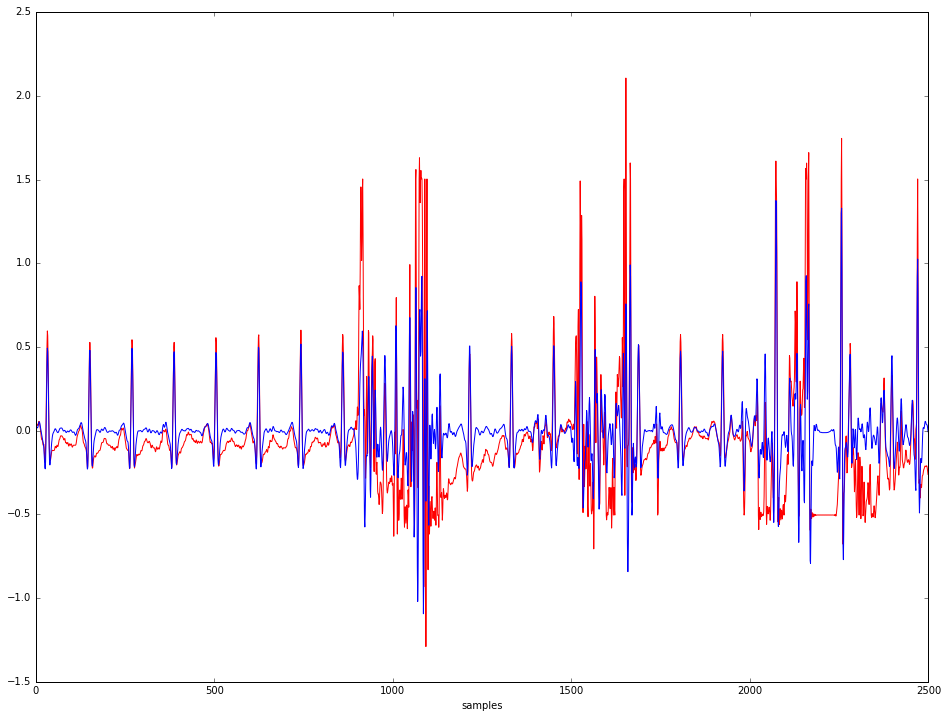

In [11]:
y = scipy.signal.filtfilt(window, 1, seg[:,0])
# plot the data 
plt.figure(figsize=[16,12])

plt.plot(seg[:,0],'r-')
plt.plot(y,'b-')
plt.xlabel('samples')
plt.show()

Buyer beware! As we can see, we have wiped out the T waves from the signal as most of their energy is < 5 Hz. There is a trade-off here: if we don't care about T waves (e.g. we are doing QRS detection), then this is fine as we only care about isolating the large spikes. However, if we want to study the morphology of the T waves (e.g. we are diagnosing a cardiac illness), then we would not want to apply this filter.

In [12]:
# simple function to create an order 50 band pass filter using a hamming window
import numpy as np
import scipy
def hamming_bandpass_filter(x,fs,f_low,f_high):
    """Create a bandpass filter between [f_low, f_high]

    """
    taps = scipy.signal.firwin(51, [f_low, f_high], nyq=np.floor(fs/2), pass_zero=False,
                  window='hamming', scale=False)
    y = scipy.signal.filtfilt(taps,1,x)
    return y